# Analyzing Neuron Output
In this problem you will train a neural network to reproduce
an image file located in the class directory at:
/lustre/haven/proj/UTK0154/data/mcm41_reduced.png
This image is a transmission electron micrograph of the structure
of MCM-41, a nanoporous material (the pore size in
the picture is of the order of 2 nm!) taken from https:
//doi-org.proxy.lib.utk.edu/10.1039/A904545G.
You are welcome to use and extend any code we have written in class
for your solution.

In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
sys.path.append('./include')
import ml4s
import json
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Part a

Load the image file using the plt.imread and normalize the pixels such that they fall between
0 and 1. This step is crucial for your ultimate analysis. Make a plot of the image (using
plt.imshow) demonstrating that you have done this (i.e. use a colorbar).

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


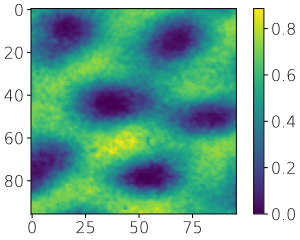

In [2]:
input=plt.imread('mcm41_reduced.png')
plt.imshow(input)
plt.colorbar()

In [3]:
input

array([[0.5568628 , 0.5254902 , 0.50980395, ..., 0.5254902 , 0.5529412 , 0.50980395],
       [0.5019608 , 0.44313726, 0.49019608, ..., 0.52156866, 0.52156866, 0.5647059 ],
       [0.5372549 , 0.5137255 , 0.52156866, ..., 0.52156866, 0.5764706 , 0.5882353 ],
       ...,
       [0.7176471 , 0.7176471 , 0.72156864, ..., 0.40392157, 0.42352942, 0.41568628],
       [0.7137255 , 0.70980394, 0.69803923, ..., 0.4862745 , 0.4392157 , 0.44313726],
       [0.7176471 , 0.7254902 , 0.7254902 , ..., 0.52156866, 0.47058824, 0.49411765]], dtype=float32)

## Part b
Use this image to create a target function. There are different ways to do this. Hint: you could
take pixel coordinates ($x_0$, $x_1$) pairs and return the image value at that pixel. You could also
take fractions and convert values 0 $\leq x_0$, $x_1 \leq$ 1 into integer pixel coordinates. Demonstrate
that this function works by plotting over some input np.meshgrid.

In [47]:
def target(x,y,data):
    num_pixels=data.shape[0]
    row=np.floor(y*num_pixels-1E-3).astype(int)
    col=np.floor(x*num_pixels-1E-3).astype(int)
    return data[row,col]

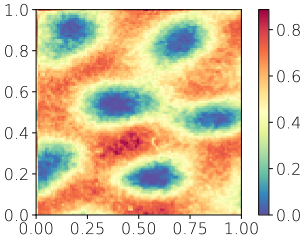

In [48]:
grid_size = 96
extent=[0.0,1.0,0.0,1.0]
X=np.meshgrid(np.linspace(extent[0],extent[1],grid_size),np.linspace(extent[2],extent[3],grid_size))
batch_size=grid_size**2

a=np.zeros([batch_size,2])
a[:,0]=X[0].flatten()
a[:,1]=X[1].flatten()

result=np.zeros_like(X[0])
for i in range(grid_size):
    for j in range(grid_size):
        x=X[0][i,j]
        y=X[1][i,j]
        result[i,j]=target(x,y,input)
        
plt.imshow(result,cmap='Spectral_r',rasterized=True,extent=extent, interpolation='nearest')
plt.colorbar()

## Part c
Train a neural network on this function (using hyperparameters of your choosing) until you
have achieved satisfactory accuracy. Make a plot of your final result and output a .json file
that stores all relevant parameters (i.e. $\eta$, neural network topology, . . . ).

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [50]:
def make_batch(n,batch_size,extent,func):
    '''Create a mini-batch from our inputs and outputs.
    Inputs:
    n        : number of neurons in each layer
    batch_size: the desired number of samples in the mini-batch
    extent    : [min(xₒ),max(xₒ), min(x₁),max(x₁),…,min(x_{n[0]-1}),max(x_{n[0]-1})]
    func:     : the desired target function.
    
    Outputs: returns the desired mini-batch of inputs and targets.
    '''
    
    x = np.zeros([batch_size,n[0]])
    for i in range(n[0]):
        x[:,i] = np.random.uniform(low=extent[2*i],high=extent[2*i+1],size=[batch_size])
        
    y = func(*[x[:,j] for j in range(n[0])],input).reshape(-1,n[-1])
    
    return x,y

In [51]:
d=layers.Dense(10, activation='relu', name="eighth")
e=layers.Dense(1, activation='sigmoid', name="output")
model = keras.Sequential(
    [
        layers.Dense(5,input_shape=(2,),activation='relu', name="input"),
        layers.Dense(50, activation='relu',name="second"),
        layers.Dense(200, activation='relu', name="third"),
        layers.Dense(100, activation='relu', name="fourth"),
        layers.Dense(200, activation='relu', name="fifth"),
        layers.Dense(100, activation='relu', name="sixth"),
        layers.Dense(50, activation='relu', name="seventh"),
        d,
        e
    ])
x,y = make_batch([2,1],10000,extent,target)
model.compile(loss='mean_squared_error', optimizer='adam')
training_history = {}
training_history['adam'] = model.fit(x=x,y=y, epochs=20,validation_split=0.2, verbose=1)

Epoch 1/20
250/250 [==============================] - 2s 4ms/step - loss: 0.0410 - val_loss: 0.0379
Epoch 2/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0373 - val_loss: 0.0382
Epoch 3/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0369 - val_loss: 0.0328
Epoch 4/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0299 - val_loss: 0.0239
Epoch 5/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0247 - val_loss: 0.0226
Epoch 6/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0197 - val_loss: 0.0181
Epoch 7/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0142 - val_loss: 0.0112
Epoch 8/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 9/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 10/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0058

Text(0.5, 1.0, 'Target')

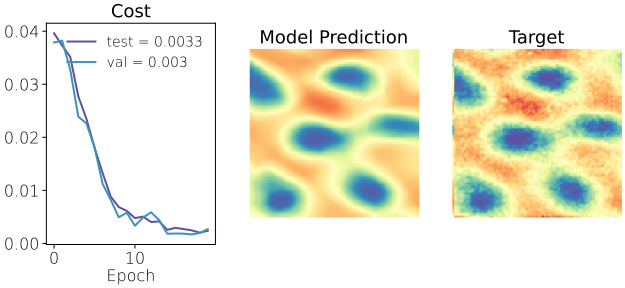

In [52]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(10,4))
        
ax[1].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[1].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[2].axis('off')
ax[2].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].plot(training_history['adam'].history['loss'], label=f'test = {np.average(training_history["adam"].history["loss"][-10:]):.2g}')
ax[0].plot(training_history['adam'].history["val_loss"], label=f'val = {np.average(training_history["adam"].history["val_loss"][-10:]):.2g}')

ax[0].legend()

ax[0].set_title("Cost")
ax[0].set_xlabel("Epoch")
ax[1].set_title("Model Prediction")
ax[2].set_title("Target")

In [53]:
data={
    "neural network topology": "[5,50,200,100,200,100,50,10,1]",
    "loss": "mean squared error",
    "optimizer" : "adam" , 
    "epochs" : 20 , 
    "validation split" : 0.2    
}
out_file = open("p3finalparameters", 'w')
json.dump(data, out_file, indent=1)
out_file.close()

## Part d
Investigate the role of individual neurons in your last hidden layer before the
output ($l$ = $L - 1$) by selectively switching weights on/off and connecting them directly to the
output layer. Produce a plot for (at least) 10 neurons. Comment on your findings.

In [65]:
weightshold=e.get_weights()
print((weightshold[1][0]))

-0.06640083


Text(0.5, 1.0, 'Target')

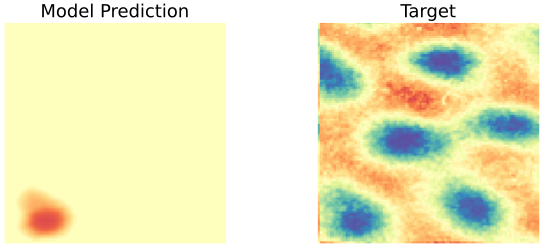

In [55]:
e1w=np.array([[1.0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])
e1b=np.array([weightshold[1][0]])
e1=np.array([e1w,e1b])
e.set_weights(e1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
        
ax[0].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[1].axis('off')
ax[1].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].set_title("Model Prediction")
ax[1].set_title("Target")

Text(0.5, 1.0, 'Target')

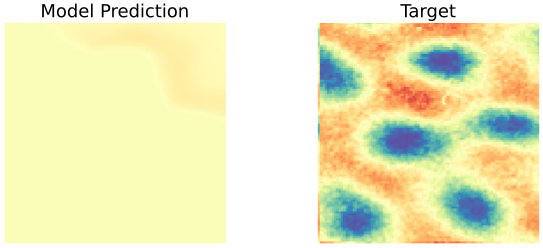

In [56]:
e1w=np.array([[0],[1.0],[0],[0],[0],[0],[0],[0],[0],[0]])
e1b=np.array([-0.06640083])
e1=np.array([e1w,e1b])
e.set_weights(e1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
        
ax[0].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[1].axis('off')
ax[1].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].set_title("Model Prediction")
ax[1].set_title("Target")

Text(0.5, 1.0, 'Target')

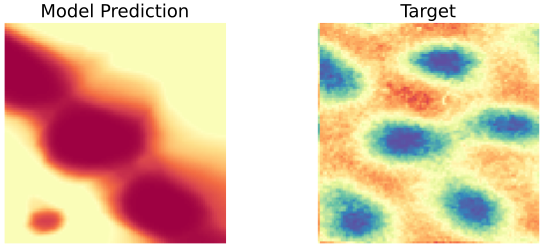

In [57]:
e1w=np.array([[0],[0],[1.0],[0],[0],[0],[0],[0],[0],[0]])
e1b=np.array([-0.06640083])
e1=np.array([e1w,e1b])
e.set_weights(e1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
        
ax[0].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[1].axis('off')
ax[1].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].set_title("Model Prediction")
ax[1].set_title("Target")

Text(0.5, 1.0, 'Target')

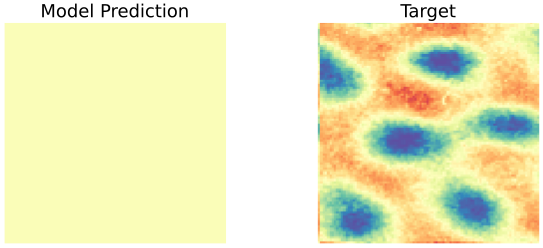

In [58]:
e1w=np.array([[0],[0],[0],[1.0],[0],[0],[0],[0],[0],[0]])
e1b=np.array([-0.06640083])
e1=np.array([e1w,e1b])
e.set_weights(e1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
        
ax[0].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[1].axis('off')
ax[1].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].set_title("Model Prediction")
ax[1].set_title("Target")

Text(0.5, 1.0, 'Target')

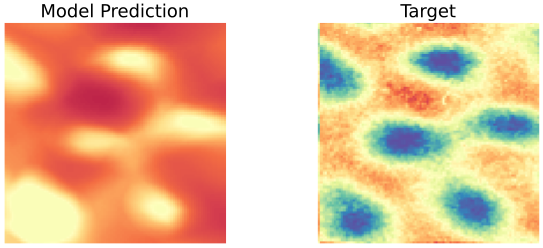

In [59]:
e1w=np.array([[0],[0],[0],[0],[1.0],[0],[0],[0],[0],[0]])
e1b=np.array([-0.06640083])
e1=np.array([e1w,e1b])
e.set_weights(e1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
        
ax[0].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[1].axis('off')
ax[1].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].set_title("Model Prediction")
ax[1].set_title("Target")

Text(0.5, 1.0, 'Target')

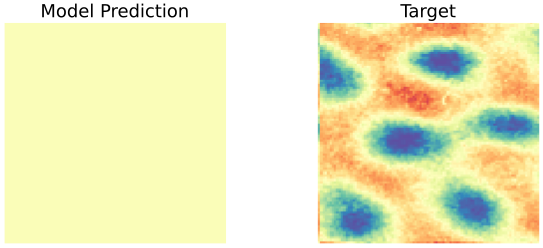

In [60]:
e1w=np.array([[0],[0],[0],[0],[0],[1.0],[0],[0],[0],[0]])
e1b=np.array([-0.06640083])
e1=np.array([e1w,e1b])
e.set_weights(e1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
        
ax[0].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[1].axis('off')
ax[1].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].set_title("Model Prediction")
ax[1].set_title("Target")

Text(0.5, 1.0, 'Target')

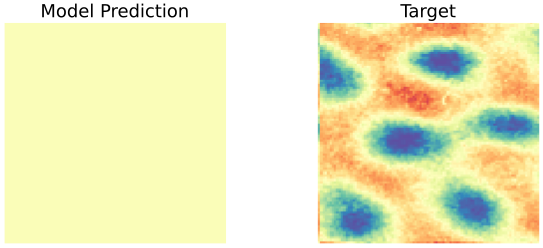

In [61]:
e1w=np.array([[0],[0],[0],[0],[0],[0],[1.0],[0],[0],[0]])
e1b=np.array([-0.06640083])
e1=np.array([e1w,e1b])
e.set_weights(e1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
        
ax[0].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[1].axis('off')
ax[1].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].set_title("Model Prediction")
ax[1].set_title("Target")

Text(0.5, 1.0, 'Target')

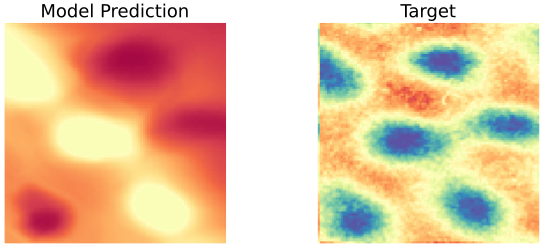

In [62]:
e1w=np.array([[0],[0],[0],[0],[0],[0],[0],[1.0],[0],[0]])
e1b=np.array([-0.06640083])
e1=np.array([e1w,e1b])
e.set_weights(e1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
        
ax[0].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[1].axis('off')
ax[1].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].set_title("Model Prediction")
ax[1].set_title("Target")

Text(0.5, 1.0, 'Target')

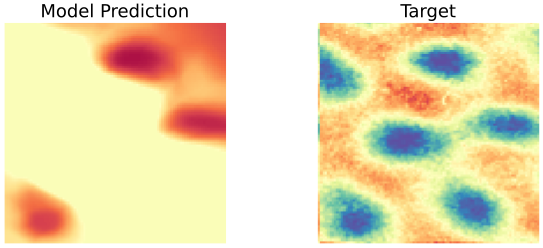

In [63]:
e1w=np.array([[0],[0],[0],[0],[0],[0],[0],[0],[1.0],[0]])
e1b=np.array([-0.06640083])
e1=np.array([e1w,e1b])
e.set_weights(e1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
        
ax[0].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[1].axis('off')
ax[1].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].set_title("Model Prediction")
ax[1].set_title("Target")

Text(0.5, 1.0, 'Target')

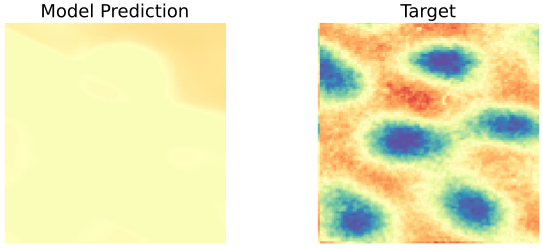

In [64]:
e1w=np.array([[0],[0],[0],[0],[0],[0],[0],[0],[0],[1.0]])
e1b=np.array([-0.06640083])
e1=np.array([e1w,e1b])
e.set_weights(e1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
        
ax[0].axis('off')

aL = model(a).numpy().reshape(grid_size,grid_size)
img = ax[0].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[1].axis('off')
ax[1].imshow(target(*X,input), extent=extent, cmap='Spectral_r', rasterized=True, 
   interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

ax[0].set_title("Model Prediction")
ax[1].set_title("Target")

### Comments:
Each neuron of the network right before the output seems to be focusing on specific areas of the output. The total output then appears to be the sum of these parts. This makes sense because the final graph of the uneditted network has higher values at the overlapping positions. 
The other interesting thing is that some neurons appear to be useless in the layer before the output. This would indicate that the size of this layer could be reduced for efficiency. This could be interpreted as the "physical" cost of the computer network.